# Import libraries

In [1]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.cluster import KMeans

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.sys.path.append('../src')
from helpers import resize_to_fit

# Load dataset

In [3]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

In [4]:
CAPTCHA_IMAGES_FOLDER = "../data/samples"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(CAPTCHA_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Grab the labels
    label = image_file.split(os.path.sep)[-1].split('.')[-2]

    # Add the image and it's label to our training data
    data.append(image)
    labels.append(label)

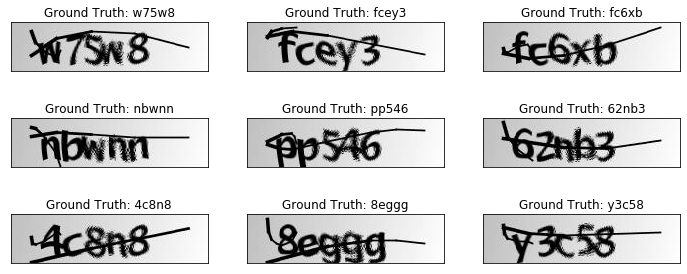

In [5]:
# show sample images
fig = plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data[i], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

# Pre-processing

## Otsu threshold

In [6]:
data_pre = []
for e in data:
    ret, th = cv2.threshold(e, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(th, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=1)

    data_pre.append(erosion)

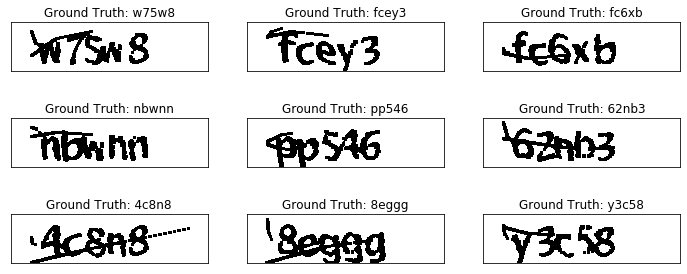

In [7]:
# show sample images
fig = plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data_pre[i], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

# K-Means

In [8]:
#data_pre = data_pre[:100]

In [9]:
data_pts = []
for e in data_pre:
    data_pts.append(np.where(e == 0))
data_pts = np.array(data_pts)
data_pts.shape

(1070, 2)

In [10]:
X = []
thres = 7
for e in data_pts:
    x = (np.vstack((e[1],np.flip(e[0])))).T
    l = []
    # Discard columns with less than thres points
    for i in range(200):
        if len(x[x[:,0] == i]) > thres:
            for f in x[x[:,0] == i]:
                l.append(f)
    x = np.array(l)
    X.append(x)
X = np.array(X)
X.shape

(1070,)

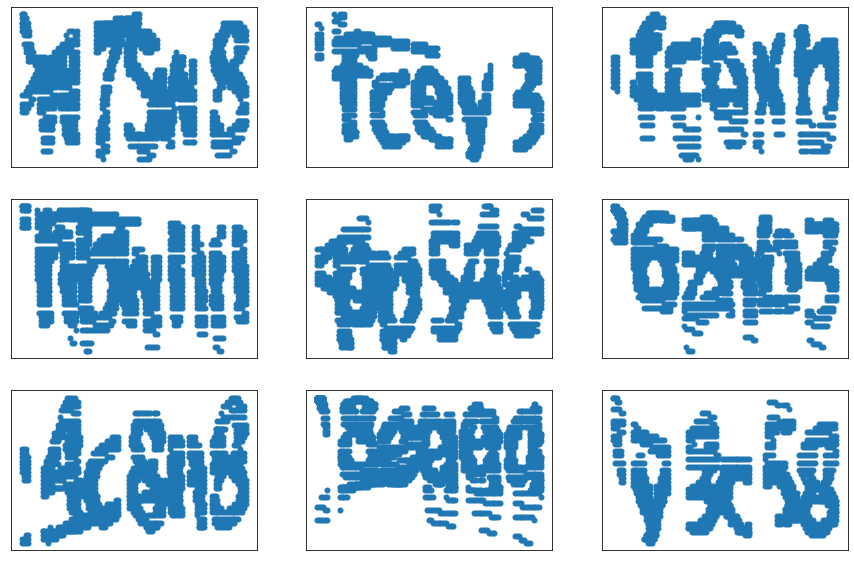

In [11]:
# Show points
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(X[i][:,0], X[i][:,1], s=100, marker='.')
    plt.xticks([])
    plt.yticks([])

In [14]:
# Projection in x-axis
X_proj = [x[:,0].reshape(-1,1) for x in X]

In [15]:
# Find clusters in projected data
y_kmeans_proj = []
centers_kmeans_proj = []
for i, x in enumerate(X_proj):
    kmeans = KMeans(n_clusters=5)#, init=np.array([(i*200/6.0, 25) for i in range(1,6)]))
    kmeans.fit(x)
    centers_kmeans_proj.append(kmeans.cluster_centers_)
    y_kmeans_proj.append(kmeans.predict(x))

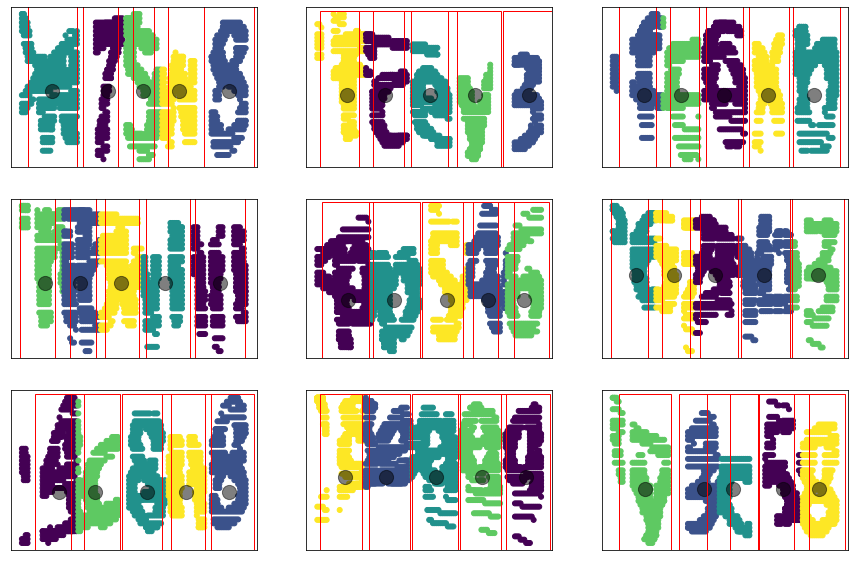

In [43]:
# Show clusters
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(X[i][:, 0], X[i][:, 1], c=y_kmeans_proj[i], s=100, cmap='viridis', marker='.')
    centers = centers_kmeans_proj[i]
    plt.scatter(centers, np.ones(centers.shape)*25, c='black', s=200, alpha=0.5, marker='o')
    plt.xticks([])
    plt.yticks([])
    currentAxis = plt.gca()
    for c in centers:
        currentAxis.add_patch(Rectangle((c - 13, 0), 26, 50, color="red", fill=False))
plt.show()

# Crop and save images

In [17]:
centers = [np.sort(e, axis=0) for e in centers_kmeans_proj]

In [18]:
centers

[array([[ 36.11545988],
        [ 65.33789954],
        [ 83.78947368],
        [102.78764479],
        [129.27714286]]), array([[ 37.37951807],
        [ 56.28082192],
        [ 78.51097179],
        [100.33185841],
        [127.06302521]]), array([[ 35.29102167],
        [ 54.15384615],
        [ 76.26020408],
        [ 98.81553398],
        [122.65714286]]), array([[ 34.18181818],
        [ 52.2364532 ],
        [ 73.18295739],
        [ 95.92857143],
        [124.5203252 ]]), array([[ 35.39121756],
        [ 59.24582339],
        [ 86.18571429],
        [107.10932476],
        [125.08888889]]), array([[ 30.92556634],
        [ 50.04067797],
        [ 70.84061697],
        [ 95.4861461 ],
        [122.77538462]]), array([[ 38.85450346],
        [ 58.04421769],
        [ 85.39095745],
        [106.35416667],
        [129.27272727]]), array([[ 33.66161616],
        [ 55.90364026],
        [ 82.78181818],
        [107.20581114],
        [130.70157068]]), array([[ 35.40547264],
        

In [19]:
data_chars = []
for i, e in enumerate(data_pre):
    chars = []
    for j in range(5):
        chars.append(e[:,int(centers[i][j]-13):int(centers[i][j]+13)])
    data_chars.append(chars)

In [20]:
letters_dir = os.path.join(data_dir, 'letters/')
letters_dir = '../data/letters'

In [21]:
if not(os.path.isdir(''.join((letters_dir)))):
    os.mkdir(''.join((letters_dir)))

for i,e in enumerate(data_chars):
    for j in range(5):
        if not(os.path.isdir(''.join((letters_dir,'/',labels[i][j],'/')))):
            os.mkdir(''.join((letters_dir,'/',labels[i][j],'/')))
        cv2.imwrite(''.join((letters_dir,'/',labels[i][j],'/',str(i),'.png')),e[j])

## Convolutional Neural Network

In [22]:
LETTER_IMAGES_FOLDER = letters_dir

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 28, 28)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


In [23]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [24]:
# Split the training data into separate train and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [25]:
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 10
log_interval = 10

In [26]:
X_train_t = (torch.from_numpy(X_train).float().transpose(1,3)).transpose(2,3)
y_train_t = torch.from_numpy(y_train).long()

train_data = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=round(batch_size_train), shuffle=True)

In [27]:
X_test_t = (torch.from_numpy(X_test).float().transpose(1,3)).transpose(2,3)
y_test_t = torch.from_numpy(y_test).long()

test_data = torch.utils.data.TensorDataset(X_test_t, y_test_t)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [28]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

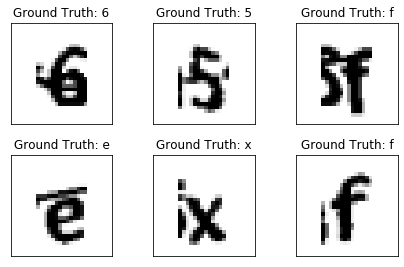

In [29]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(le.inverse_transform(example_targets)[i]))
    plt.xticks([])
    plt.yticks([])

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 32)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)

In [31]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [32]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [33]:
def train(epoch, v=True):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if v:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [34]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [35]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 6.6405, Accuracy: 29/1200 (2%)

Train Epoch: 1 [0/3597 (0%)]	Loss: 4.603735
Train Epoch: 1 [1000/3597 (28%)]	Loss: 4.573993
Train Epoch: 1 [2000/3597 (56%)]	Loss: 4.202021
Train Epoch: 1 [3000/3597 (83%)]	Loss: 3.915564

Test set: Avg. loss: 5.5971, Accuracy: 709/1200 (59%)

Train Epoch: 2 [0/3597 (0%)]	Loss: 3.772146
Train Epoch: 2 [1000/3597 (28%)]	Loss: 3.694736
Train Epoch: 2 [2000/3597 (56%)]	Loss: 3.381001
Train Epoch: 2 [3000/3597 (83%)]	Loss: 3.442278

Test set: Avg. loss: 4.9109, Accuracy: 881/1200 (73%)

Train Epoch: 3 [0/3597 (0%)]	Loss: 3.411240
Train Epoch: 3 [1000/3597 (28%)]	Loss: 3.429502
Train Epoch: 3 [2000/3597 (56%)]	Loss: 3.322206
Train Epoch: 3 [3000/3597 (83%)]	Loss: 3.174467

Test set: Avg. loss: 4.6816, Accuracy: 912/1200 (76%)

Train Epoch: 4 [0/3597 (0%)]	Loss: 3.182055
Train Epoch: 4 [1000/3597 (28%)]	Loss: 3.070203
Train Epoch: 4 [2000/3597 (56%)]	Loss: 2.958497
Train Epoch: 4 [3000/3597 (83%)]	Loss: 3.100992

Test set: Avg. loss: 4.60

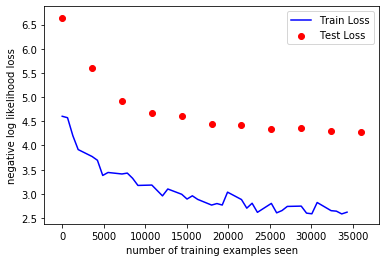

In [36]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [37]:
with torch.no_grad():
    output = net(example_data)
    print(output.data)

tensor([[-14.8682, -11.7405, -15.1880,  ...,  -5.9919,  -6.6210,  -7.5043],
        [-12.7773,  -7.2843, -17.5217,  ...,  -6.0719,  -5.8579,  -6.9371],
        [ -8.7127,  -8.1356,  -6.8515,  ...,  -7.2052,  -7.3416,  -6.9728],
        ...,
        [-14.5924,  -9.0978, -15.2330,  ...,  -6.4889,  -8.2033,  -6.1991],
        [ -8.9459, -10.3736,  -3.2922,  ...,  -7.5749,  -6.3003,  -6.5333],
        [-10.9454,  -4.0845, -14.9283,  ...,  -7.1758,  -6.9540,  -7.0148]])


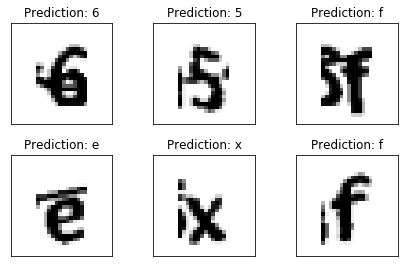

In [38]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(le.inverse_transform(output.data.max(1, keepdim=True)[1][i])[0]))
    plt.xticks([])
    plt.yticks([])

In [39]:
class Net(nn.Module):
    def __init__(self, H, D):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 32)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)


Net with H = 50, D = 0

Test set: Avg. loss: 6.6401, Accuracy: 24/1200 (2%)


Test set: Avg. loss: 5.4622, Accuracy: 729/1200 (60%)


Test set: Avg. loss: 4.8704, Accuracy: 885/1200 (73%)


Test set: Avg. loss: 4.6423, Accuracy: 943/1200 (78%)


Test set: Avg. loss: 4.4914, Accuracy: 969/1200 (80%)


Test set: Avg. loss: 4.3933, Accuracy: 989/1200 (82%)


Test set: Avg. loss: 4.3608, Accuracy: 997/1200 (83%)


Test set: Avg. loss: 4.3414, Accuracy: 1017/1200 (84%)


Test set: Avg. loss: 4.3116, Accuracy: 1019/1200 (84%)


Test set: Avg. loss: 4.2595, Accuracy: 1026/1200 (85%)


Test set: Avg. loss: 4.2653, Accuracy: 1017/1200 (84%)



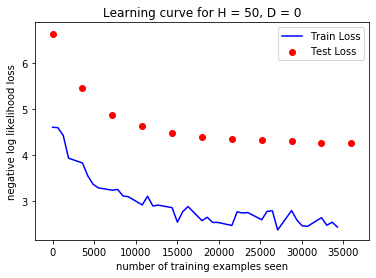


Net with H = 50, D = 0.3

Test set: Avg. loss: 6.6406, Accuracy: 34/1200 (2%)


Test set: Avg. loss: 5.4668, Accuracy: 743/1200 (61%)


Test set: Avg. loss: 4.8499, Accuracy: 916/1200 (76%)


Test set: Avg. loss: 4.6824, Accuracy: 936/1200 (78%)


Test set: Avg. loss: 4.4809, Accuracy: 977/1200 (81%)


Test set: Avg. loss: 4.3941, Accuracy: 988/1200 (82%)


Test set: Avg. loss: 4.3795, Accuracy: 977/1200 (81%)


Test set: Avg. loss: 4.3498, Accuracy: 1007/1200 (83%)


Test set: Avg. loss: 4.3083, Accuracy: 1007/1200 (83%)


Test set: Avg. loss: 4.2680, Accuracy: 1016/1200 (84%)


Test set: Avg. loss: 4.2816, Accuracy: 1029/1200 (85%)



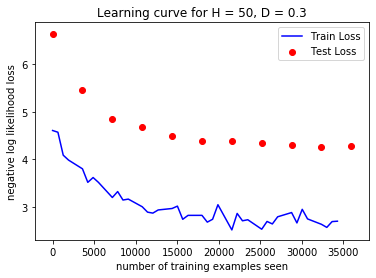


Net with H = 50, D = 0.5

Test set: Avg. loss: 6.6387, Accuracy: 45/1200 (3%)


Test set: Avg. loss: 5.1555, Accuracy: 875/1200 (72%)


Test set: Avg. loss: 4.6515, Accuracy: 971/1200 (80%)


Test set: Avg. loss: 4.4307, Accuracy: 1010/1200 (84%)


Test set: Avg. loss: 4.3360, Accuracy: 1009/1200 (84%)


Test set: Avg. loss: 4.2887, Accuracy: 1017/1200 (84%)


Test set: Avg. loss: 4.2831, Accuracy: 1019/1200 (84%)


Test set: Avg. loss: 4.2118, Accuracy: 1046/1200 (87%)


Test set: Avg. loss: 4.2132, Accuracy: 1047/1200 (87%)


Test set: Avg. loss: 4.1915, Accuracy: 1042/1200 (86%)


Test set: Avg. loss: 4.1969, Accuracy: 1037/1200 (86%)



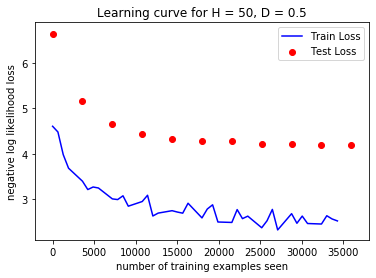


Net with H = 50, D = 0.7

Test set: Avg. loss: 6.6399, Accuracy: 32/1200 (2%)


Test set: Avg. loss: 6.2203, Accuracy: 414/1200 (34%)


Test set: Avg. loss: 5.5183, Accuracy: 675/1200 (56%)


Test set: Avg. loss: 5.1394, Accuracy: 780/1200 (65%)


Test set: Avg. loss: 4.9907, Accuracy: 847/1200 (70%)


Test set: Avg. loss: 4.8701, Accuracy: 866/1200 (72%)


Test set: Avg. loss: 4.7447, Accuracy: 877/1200 (73%)


Test set: Avg. loss: 4.6991, Accuracy: 901/1200 (75%)


Test set: Avg. loss: 4.6786, Accuracy: 907/1200 (75%)


Test set: Avg. loss: 4.5683, Accuracy: 921/1200 (76%)


Test set: Avg. loss: 4.6014, Accuracy: 928/1200 (77%)



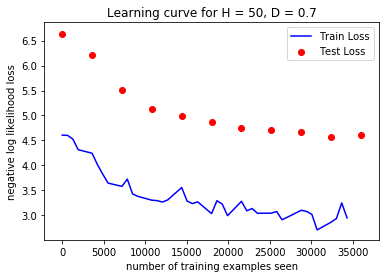


Net with H = 120, D = 0

Test set: Avg. loss: 6.6423, Accuracy: 11/1200 (0%)


Test set: Avg. loss: 5.5857, Accuracy: 753/1200 (62%)


Test set: Avg. loss: 4.8048, Accuracy: 913/1200 (76%)


Test set: Avg. loss: 4.5944, Accuracy: 980/1200 (81%)


Test set: Avg. loss: 4.4888, Accuracy: 987/1200 (82%)


Test set: Avg. loss: 4.3616, Accuracy: 1000/1200 (83%)


Test set: Avg. loss: 4.3182, Accuracy: 1009/1200 (84%)


Test set: Avg. loss: 4.2790, Accuracy: 1011/1200 (84%)


Test set: Avg. loss: 4.2610, Accuracy: 1017/1200 (84%)


Test set: Avg. loss: 4.2531, Accuracy: 1022/1200 (85%)


Test set: Avg. loss: 4.2241, Accuracy: 1018/1200 (84%)



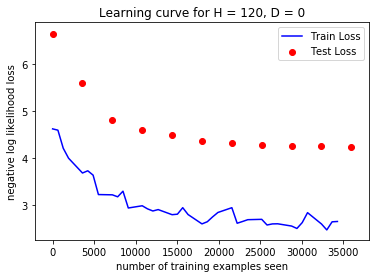


Net with H = 120, D = 0.3

Test set: Avg. loss: 6.6385, Accuracy: 32/1200 (2%)


Test set: Avg. loss: 5.3486, Accuracy: 799/1200 (66%)


Test set: Avg. loss: 4.7979, Accuracy: 922/1200 (76%)


Test set: Avg. loss: 4.4704, Accuracy: 990/1200 (82%)


Test set: Avg. loss: 4.3419, Accuracy: 1009/1200 (84%)


Test set: Avg. loss: 4.2988, Accuracy: 1008/1200 (84%)


Test set: Avg. loss: 4.2498, Accuracy: 1030/1200 (85%)


Test set: Avg. loss: 4.2455, Accuracy: 1018/1200 (84%)


Test set: Avg. loss: 4.2092, Accuracy: 1033/1200 (86%)


Test set: Avg. loss: 4.1955, Accuracy: 1050/1200 (87%)


Test set: Avg. loss: 4.1796, Accuracy: 1063/1200 (88%)



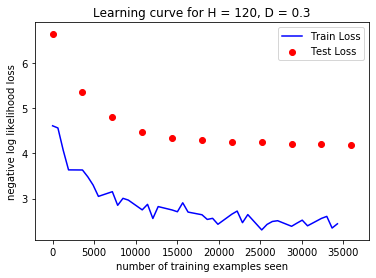


Net with H = 120, D = 0.5

Test set: Avg. loss: 6.6399, Accuracy: 43/1200 (3%)


Test set: Avg. loss: 5.3309, Accuracy: 815/1200 (67%)


Test set: Avg. loss: 4.7019, Accuracy: 912/1200 (76%)


Test set: Avg. loss: 4.4590, Accuracy: 963/1200 (80%)


Test set: Avg. loss: 4.3756, Accuracy: 995/1200 (82%)


Test set: Avg. loss: 4.3203, Accuracy: 1008/1200 (84%)


Test set: Avg. loss: 4.2903, Accuracy: 1002/1200 (83%)


Test set: Avg. loss: 4.2673, Accuracy: 1020/1200 (85%)


Test set: Avg. loss: 4.2563, Accuracy: 1010/1200 (84%)


Test set: Avg. loss: 4.2370, Accuracy: 1025/1200 (85%)


Test set: Avg. loss: 4.2413, Accuracy: 1030/1200 (85%)



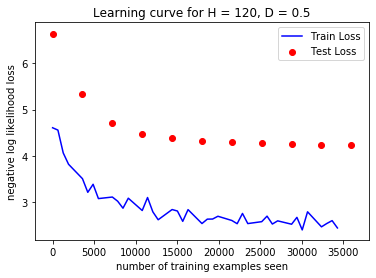


Net with H = 120, D = 0.7

Test set: Avg. loss: 6.6401, Accuracy: 22/1200 (1%)


Test set: Avg. loss: 5.3597, Accuracy: 747/1200 (62%)


Test set: Avg. loss: 4.7783, Accuracy: 924/1200 (77%)


Test set: Avg. loss: 4.5729, Accuracy: 953/1200 (79%)


Test set: Avg. loss: 4.4376, Accuracy: 986/1200 (82%)


Test set: Avg. loss: 4.3882, Accuracy: 989/1200 (82%)


Test set: Avg. loss: 4.3253, Accuracy: 1011/1200 (84%)


Test set: Avg. loss: 4.3046, Accuracy: 1017/1200 (84%)


Test set: Avg. loss: 4.2812, Accuracy: 1020/1200 (85%)


Test set: Avg. loss: 4.2587, Accuracy: 1026/1200 (85%)


Test set: Avg. loss: 4.2438, Accuracy: 1027/1200 (85%)



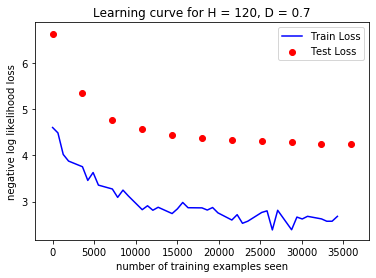


Net with H = 320, D = 0

Test set: Avg. loss: 6.6401, Accuracy: 27/1200 (2%)


Test set: Avg. loss: 5.6801, Accuracy: 663/1200 (55%)


Test set: Avg. loss: 4.8357, Accuracy: 918/1200 (76%)


Test set: Avg. loss: 4.5924, Accuracy: 963/1200 (80%)


Test set: Avg. loss: 4.3902, Accuracy: 991/1200 (82%)


Test set: Avg. loss: 4.3151, Accuracy: 997/1200 (83%)


Test set: Avg. loss: 4.2779, Accuracy: 1028/1200 (85%)


Test set: Avg. loss: 4.2405, Accuracy: 1043/1200 (86%)


Test set: Avg. loss: 4.2423, Accuracy: 1025/1200 (85%)


Test set: Avg. loss: 4.1973, Accuracy: 1051/1200 (87%)


Test set: Avg. loss: 4.2165, Accuracy: 1057/1200 (88%)



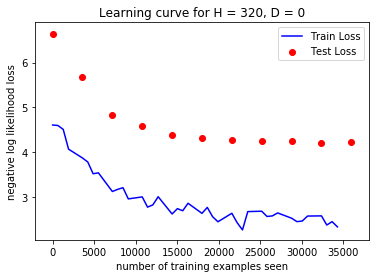


Net with H = 320, D = 0.3

Test set: Avg. loss: 6.6407, Accuracy: 25/1200 (2%)


Test set: Avg. loss: 5.3018, Accuracy: 771/1200 (64%)


Test set: Avg. loss: 4.9080, Accuracy: 892/1200 (74%)


Test set: Avg. loss: 4.7348, Accuracy: 908/1200 (75%)


Test set: Avg. loss: 4.5988, Accuracy: 941/1200 (78%)


Test set: Avg. loss: 4.4619, Accuracy: 976/1200 (81%)


Test set: Avg. loss: 4.4232, Accuracy: 973/1200 (81%)


Test set: Avg. loss: 4.4104, Accuracy: 977/1200 (81%)


Test set: Avg. loss: 4.3517, Accuracy: 976/1200 (81%)


Test set: Avg. loss: 4.3268, Accuracy: 994/1200 (82%)


Test set: Avg. loss: 4.3195, Accuracy: 974/1200 (81%)



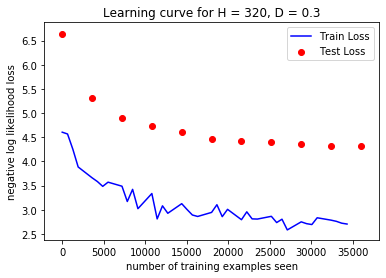


Net with H = 320, D = 0.5

Test set: Avg. loss: 6.6396, Accuracy: 36/1200 (3%)


Test set: Avg. loss: 5.1227, Accuracy: 864/1200 (72%)


Test set: Avg. loss: 4.5988, Accuracy: 983/1200 (81%)


Test set: Avg. loss: 4.3701, Accuracy: 1007/1200 (83%)


Test set: Avg. loss: 4.2717, Accuracy: 1037/1200 (86%)


Test set: Avg. loss: 4.2244, Accuracy: 1061/1200 (88%)


Test set: Avg. loss: 4.2065, Accuracy: 1063/1200 (88%)


Test set: Avg. loss: 4.1777, Accuracy: 1068/1200 (89%)


Test set: Avg. loss: 4.1606, Accuracy: 1060/1200 (88%)


Test set: Avg. loss: 4.1784, Accuracy: 1075/1200 (89%)


Test set: Avg. loss: 4.1583, Accuracy: 1069/1200 (89%)



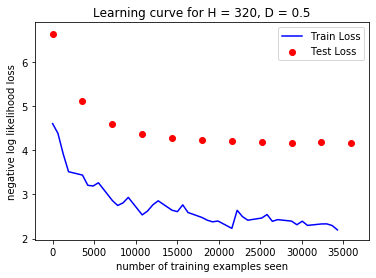


Net with H = 320, D = 0.7

Test set: Avg. loss: 6.6388, Accuracy: 53/1200 (4%)


Test set: Avg. loss: 5.6069, Accuracy: 772/1200 (64%)


Test set: Avg. loss: 4.8406, Accuracy: 919/1200 (76%)


Test set: Avg. loss: 4.5303, Accuracy: 985/1200 (82%)


Test set: Avg. loss: 4.4219, Accuracy: 987/1200 (82%)


Test set: Avg. loss: 4.3710, Accuracy: 1026/1200 (85%)


Test set: Avg. loss: 4.3266, Accuracy: 1022/1200 (85%)


Test set: Avg. loss: 4.2707, Accuracy: 1027/1200 (85%)


Test set: Avg. loss: 4.2547, Accuracy: 1040/1200 (86%)


Test set: Avg. loss: 4.2251, Accuracy: 1043/1200 (86%)


Test set: Avg. loss: 4.2097, Accuracy: 1048/1200 (87%)



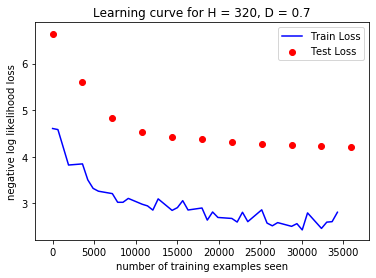

In [41]:
n_epochs = 10

for H in [50, 120, 320]:
    for D in [0, 0.3, 0.5, 0.7]:
        net = Net(H, D)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
        
        train_losses = []
        train_counter = []
        test_losses = []
        test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
        
        print("\nNet with H = {}, D = {}".format(H, D))
        
        test()
        for epoch in range(1, n_epochs + 1):
            train(epoch, False)
            test()
            
        fig = plt.figure()
        plt.plot(train_counter, train_losses, color='blue')
        plt.scatter(test_counter, test_losses, color='red')
        plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
        plt.xlabel('number of training examples seen')
        plt.ylabel('negative log likelihood loss')
        plt.title('Learning curve for H = {}, D = {}'.format(H, D))
        plt.show()   

http://ceur-ws.org/Vol-1885/93.pdf
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/34843.pdf